In [81]:
import pandas as pd
import numpy as np
import pathlib
from gensim import corpora
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import json

In [82]:
import os

# Set the number of threads to use
os.environ["OMP_NUM_THREADS"] = "10"

In [83]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [84]:
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/models/filtering/rosie_1_20")
path_save = pathlib.Path("export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/active_learning")

In [85]:
fig_width = 6  # inches
fig_height = 4.5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 22,

    # Axes
    'axes.labelsize': 22,
    'axes.titlesize': 22,  # Increase this value for larger axes titles
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 16,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 3,
    'lines.markersize': 8,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
})

## Auxiliary functions

In [86]:
def identify_bad_documents_v2(thetas, betas, documents_texts, vocab_w2id):
    D = len(thetas)
    K = len(betas)
    S3 = np.zeros((D, K))

    for doc in range(D):
        for topic in range(K):
            wd_ids = [vocab_w2id[word]
                      for word in documents_texts[doc] if word in vocab_w2id]
            S3[doc, topic] = np.sum(betas[topic, wd_ids])

    return S3

## Read corpus

In [87]:
language = "ES"

In [88]:
corpusFile = pathlib.Path(f"/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/models/filtering/rosie_1_20/train_data/corpus_{language}.txt")
with corpusFile.open("r", encoding="utf-8") as f:
    lines = [line for line in f.readlines()]
corpus = [line.rsplit(" 0 ")[1].strip().split() for line in lines]#if line.rsplit(" 0 ")[1].strip().split() != []
ids = [line.split(" 0 ")[0] for line in lines]


df_model = pd.DataFrame({"lemmas": [" ".join(doc) for doc in corpus], "id": ids})
df_model["id_top"] = range(len(df_model))
df_model["len"] = df_model['lemmas'].apply(lambda x: len(x.split()))
df_model["tokenized_text"] = df_model['lemmas']
df_model["text_split"] = df_model["tokenized_text"].apply(lambda x: x.split())

df_model.head()

,lemmas,id,id_top,len,tokenized_text,text_split
0,causas interno oído contener célula_pilosa dim...,ES_953747_124620-3,0,13,causas interno oído contener célula_pilosa dim...,"[causas, interno, oído, contener, célula_pilos..."
1,especial caso meduloblastomas desenlace relaci...,ES_490955_64059-16,1,36,especial caso meduloblastomas desenlace relaci...,"[especial, caso, meduloblastomas, desenlace, r..."
2,paciente glioma_difuso línea medio alteración ...,ES_533943_64846-86,2,9,paciente glioma_difuso línea medio alteración ...,"[paciente, glioma_difuso, línea, medio, altera..."
3,guía destinado facilitar coordinador utilícela...,ES_44759_12033-16,3,24,guía destinado facilitar coordinador utilícela...,"[guía, destinado, facilitar, coordinador, util..."
4,recibir suspensión_liberación prolongado_azitr...,ES_1012862_127780-5,4,34,recibir suspensión_liberación prolongado_azitr...,"[recibir, suspensión_liberación, prolongado_az..."


## Get model info

In [89]:
thetas = sparse.load_npz(path_model.joinpath(f'mallet_output/{language}/thetas.npz')).toarray()
betas = np.load(path_model.joinpath(f'mallet_output/{language}/betas.npy'))

vocab_w2id = {}
vocab_id2w = {}
with path_model.joinpath(f'mallet_output/{language}/vocab_freq.txt').open('r', encoding='utf8') as fin:
    for i, line in enumerate(fin):
        wd = line.split()[0].strip()
        vocab_w2id[wd] = i
        vocab_id2w[str(i)] = wd

s3 = identify_bad_documents_v2(thetas,betas,corpus,vocab_w2id)

In [90]:
with (path_model / f"mallet_output/{language}/topickeys.txt").open('r', encoding='utf8') as fin:
    topic_keys= [el.split("\t")[-1].strip().split() for el in fin.readlines()]
#topics_keys 
#with (path_cancer / "TMmodel/tpc_labels.txt").open('r', encoding='utf8') as fin:
#    tpc_labels_cancer = [el.strip() for el in fin.readlines()]

In [91]:
def count_occurrences(row, external_list):
    return sum(row.count(item) for item in external_list)

def count_different_occurrences(row, external_list):
    this_doc_tpc_words = [word for word in row if word in external_list]
    unique_words = list(set(this_doc_tpc_words))
    return len(unique_words)

def get_thetas_str(row,thetas):
    return " ".join([f"{id_}|{el}" for id_,el in enumerate(thetas[row]) if el!=0.0])

def get_most_representative_per_tpc(mat, topn=10):
    # Find the most representative document for each topic based on a matrix mat
    top_docs_per_topic = []

    for doc_distr in mat.T:  
        sorted_docs_indices = np.argsort(doc_distr)[::-1]
        top = sorted_docs_indices[:topn].tolist()
        top_docs_per_topic.append(top)
    return top_docs_per_topic

def get_df_results(mats, topics_keys):
    top_docs_mats = {}
    for (name, mat) in mats:
        top_docs_mats[name] = get_most_representative_per_tpc(mat,5)
    #print(top_docs_mats)
    rows = []
    for topic in range(mats[0][1].shape[1]):
        topic_keys = topics_keys[topic]
        top_docs = []
        for name in top_docs_mats.keys():
            top_docs_text = ""
            top_docs_mats_topic = top_docs_mats[name][topic]
            for doc_id in top_docs_mats_topic:
                #print(doc_id)
                top_docs_text += f"ID: {doc_id}: TEXT: {df[df.id_top == doc_id].tokenized_text.values.tolist()[0][0:100]} \n"
            top_docs_text.strip()
            top_docs.append(top_docs_text)
        row = [
            topic, topic_keys, *top_docs
        ]
        rows.append(row)
    columns = ["Topic ID", "Topic Keys", "Thetas Top docs", "S3 top docs"]
    df_results = pd.DataFrame(rows, columns=columns)
    return df_results

def get_df_results_count_thetas(mats, topics_keys, nr_docs=5):
    top_docs_mats = {}
    for (name, mat) in mats:
        top_docs_mats[name] = get_most_representative_per_tpc(mat,nr_docs)
    
    dfs = {}
    for name in top_docs_mats.keys(): # para cada método de selección
        rows = []        
        for topic in range(mats[0][1].shape[1]): # para cada tópico
            top_docs_mats_topic = top_docs_mats[name][topic] #cogemos la matriz
            topic_keys = topics_keys[topic]
            
            for doc_id in top_docs_mats_topic: # para cada top doc
                sims_info_doc = []
                top_doc_text = df[df.id_top == doc_id].tokenized_text.values.tolist()#[0][0:100] # el documento
                top_doc_lemmas_tpc_count = df[df.id_top == doc_id][f"top_word_occur_topic_{topic}"].values.tolist()[0] # el número de top lemmas
                top_doc_lemmas_unique = df[df.id_top == doc_id][f"count_top_word_occur_topic_{topic}"].values.tolist()[0] # el número de top lemmas sin repeticiones
                #import pdb; pdb.set_trace()
                top_doc_thetas = thetas[df[df.id_top == doc_id].id_top,topic][0]
                sims_info_doc.append(doc_id)
                sims_info_doc.append(top_doc_text)
                sims_info_doc.append(top_doc_lemmas_tpc_count)
                sims_info_doc.append(top_doc_lemmas_unique)
                sims_info_doc.append(top_doc_thetas)
                #import pdb; pdb.set_trace()
                row = [
                    topic, topic_keys, *sims_info_doc
                ]
                rows.append(row)
                
        columns = ["Topic ID", "Topic Keys", "Top doc id", f"{name} Top docs", f"{name} Lemmas Count", f"{name} Unique Lemmas Count", f"{name} Top docs thetas"]
        df_results = pd.DataFrame(rows, columns=columns)
        dfs[name] = df_results
    return dfs

# Results

- **Thetas Top docs** = Top docs are determined by selecting those with the highest thetas for each topic.
- **S all Top docs** = Top docs are selected based on the largest Bhattacharya coefficient between their normalized BoW and the betas.
- **S part Top docs** = Top docs are chosen by identifying those with the largest Bhattacharya coefficient between the BoW of the document, specific to the words generated for the topic, and the topic's betas.

In [92]:
df_raw = df_model.copy()

In [93]:
# Copy to apply calculations just for Mallet
df = df_raw.copy()

mats = [
    ("thetas", thetas),
    ("S3", s3),
]
    
# Get betas top words for each topic
top_words = 10
top_indices = np.argsort(-betas, axis=1)[:, :top_words]

topics_top_words = [[vocab_id2w[str(word_id)] for word_id in row] for row in top_indices] # just top-words

for tpc in range(len(topics_top_words)):
    df[f'top_word_occur_topic_{tpc}'] = df.apply(lambda row: count_occurrences(row['tokenized_text'].split(), topics_top_words[tpc]), axis=1)
    df[f'count_top_word_occur_topic_{tpc}'] = df.apply(lambda row: count_different_occurrences(row['tokenized_text'].split(), topics_top_words[tpc]), axis=1)

df.head()

,lemmas,id,id_top,len,tokenized_text,text_split,top_word_occur_topic_0,count_top_word_occur_topic_0,top_word_occur_topic_1,count_top_word_occur_topic_1,...,top_word_occur_topic_15,count_top_word_occur_topic_15,top_word_occur_topic_16,count_top_word_occur_topic_16,top_word_occur_topic_17,count_top_word_occur_topic_17,top_word_occur_topic_18,count_top_word_occur_topic_18,top_word_occur_topic_19,count_top_word_occur_topic_19
0,causas interno oído contener célula_pilosa dim...,ES_953747_124620-3,0,13,causas interno oído contener célula_pilosa dim...,"[causas, interno, oído, contener, célula_pilos...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,especial caso meduloblastomas desenlace relaci...,ES_490955_64059-16,1,36,especial caso meduloblastomas desenlace relaci...,"[especial, caso, meduloblastomas, desenlace, r...",1,1,1,1,...,0,0,0,0,1,1,0,0,3,2
2,paciente glioma_difuso línea medio alteración ...,ES_533943_64846-86,2,9,paciente glioma_difuso línea medio alteración ...,"[paciente, glioma_difuso, línea, medio, altera...",0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,guía destinado facilitar coordinador utilícela...,ES_44759_12033-16,3,24,guía destinado facilitar coordinador utilícela...,"[guía, destinado, facilitar, coordinador, util...",2,2,3,3,...,0,0,0,0,0,0,1,1,1,1
4,recibir suspensión_liberación prolongado_azitr...,ES_1012862_127780-5,4,34,recibir suspensión_liberación prolongado_azitr...,"[recibir, suspensión_liberación, prolongado_az...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
#df["thetas"] = df.apply(lambda row: get_thetas_str(row['id_top'], thetas), axis=1)
df["thetas"] = df.apply(lambda row: thetas[row['id_top']], axis=1)

In [95]:
dfs = get_df_results_count_thetas(mats, topic_keys)

In [96]:
dfs["S3"]

,Topic ID,Topic Keys,Top doc id,S3 Top docs,S3 Lemmas Count,S3 Unique Lemmas Count,S3 Top docs thetas
0,0,"[síntoma, persona, infección, enfermedad, caus...",745027,[mostrar doctor disponible disponible sagar_du...,28,3,0.278832
1,0,"[síntoma, persona, infección, enfermedad, caus...",751113,[persona vih enfermedad coronavirus persona vi...,28,2,0.000000
2,0,"[síntoma, persona, infección, enfermedad, caus...",902549,[correr alto riesgo contagiar él infección gra...,27,6,0.949638
3,0,"[síntoma, persona, infección, enfermedad, caus...",460884,[got enfermedad pulmonar_obstructiva crónica_i...,26,4,0.000000
4,0,"[síntoma, persona, infección, enfermedad, caus...",27933,[got enfermedad pulmonar_obstructiva crónica_i...,26,4,0.000000
...,...,...,...,...,...,...,...
95,19,"[él, caso, forma, nivel, modelo, grupo, anális...",940398,[título_descripción categoría autor fecha form...,0,0,0.033229
96,19,"[él, caso, forma, nivel, modelo, grupo, anális...",145094,[pdf_comentarios público escrito mayo pdf jere...,1,1,0.048189
97,19,"[él, caso, forma, nivel, modelo, grupo, anális...",143828,[filtrar_título filtrar_título nombre descripc...,35,1,0.138153
98,19,"[él, caso, forma, nivel, modelo, grupo, anális...",32118,[filtrar_título nombre descripción_presentado ...,10,2,0.000000


thetas Lemmas Count
S3 Lemmas Count
thetas Unique Lemmas Count
S3 Unique Lemmas Count


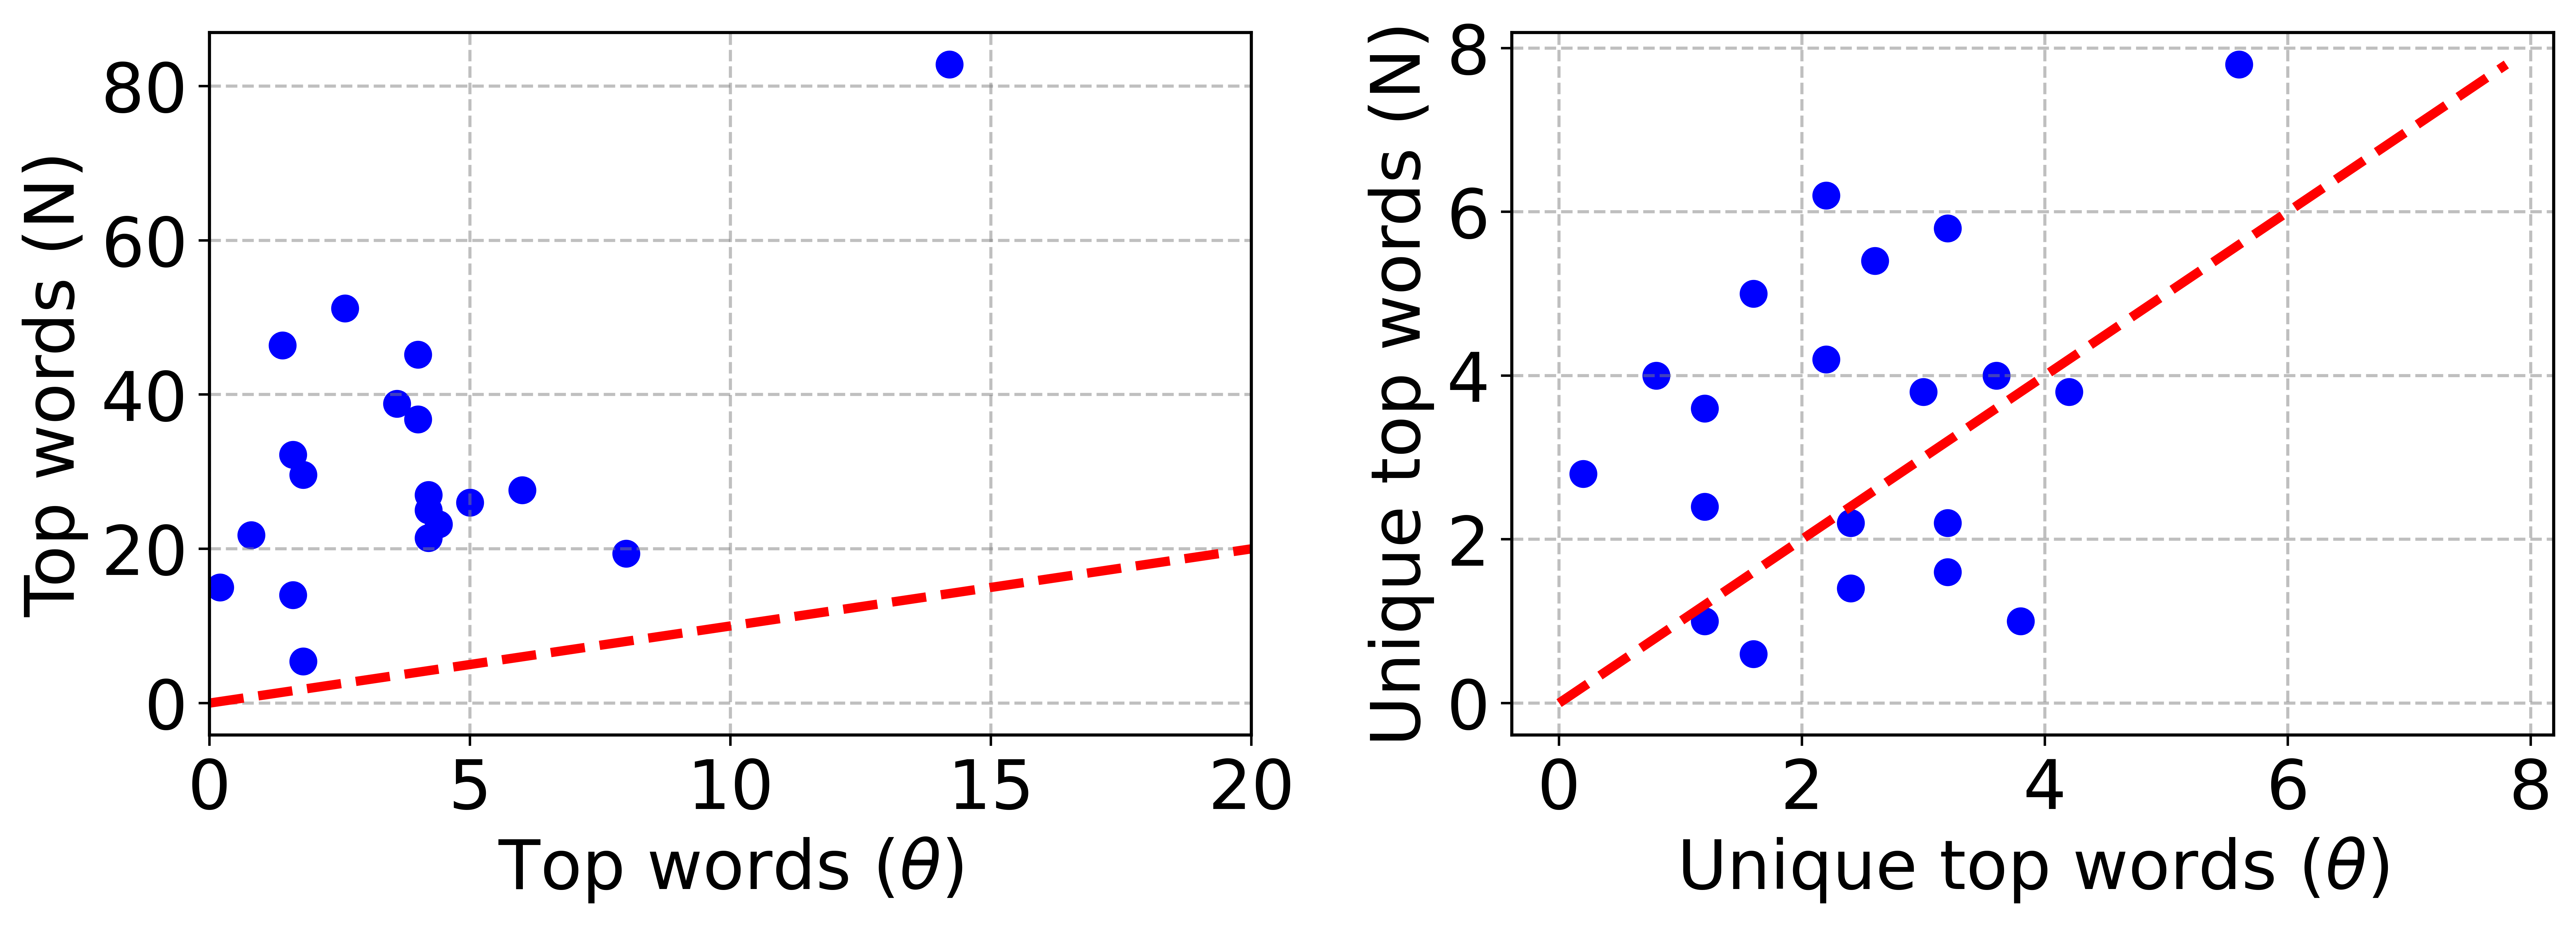

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

# Plot 1
to_plot = {}
for name in dfs.keys():
    df_aux = dfs[name].copy()
    columns_eval = df_aux.columns.tolist()[4]
    print(columns_eval)
    average_by_index = df_aux.groupby('Topic ID')[columns_eval].mean().values.tolist()
    std_by_index = df_aux.groupby('Topic ID')[columns_eval].std().values.tolist()  # Calculate standard deviation
    to_plot[name] = average_by_index

to_plot["Topic ID"] = range(len(average_by_index))
df_to_plot1 = pd.DataFrame(to_plot)

# Plot 2
to_plot = {}
for name in dfs.keys():
    df_aux = dfs[name].copy()
    columns_eval = df_aux.columns.tolist()[5]
    print(columns_eval)
    average_by_index = df_aux.groupby('Topic ID')[columns_eval].mean().values.tolist()
    to_plot[name] = average_by_index

to_plot["Topic ID"] = range(len(average_by_index))
df_to_plot2 = pd.DataFrame(to_plot)

# Scatter plot 1
ax1.scatter(df_to_plot1['thetas'], df_to_plot1['S3'], color='blue')
ax1.set_xlabel(r'Top words ($\theta$)')
ax1.set_ylabel("Top words (N)")
#ax1.set_title("Comparison of average words")
ax1.grid(True, linestyle='--', color='gray', alpha=0.5)
ax1.set_xlim(0, 20)  # Set x-axis limit to 50

# Adding diagonal line y=x
max_value1 = max(max(df_to_plot1['thetas']), max(df_to_plot1['S3']))
ax1.plot([0, max_value1], [0, max_value1], color='red', linestyle='--')

# Scatter plot 2
ax2.scatter(df_to_plot2['thetas'], df_to_plot2['S3'], color='blue')
ax2.set_xlabel(r'Unique top words ($\theta$)')
ax2.set_ylabel("Unique top words (N)")
#ax2.set_title("Comparison of average unique words")
ax2.grid(True, linestyle='--', color='gray', alpha=0.5)
#ax2.set_xlim(0, 50)  # Set x-axis limit to 50

# Adding diagonal line y=x
max_value2 = max(max(df_to_plot2['thetas']), max(df_to_plot2['S3']))
ax2.plot([0, max_value2], [0, max_value2], color='red', linestyle='--')

plt.tight_layout()
#plotFile = path_save.joinpath(tm_method)
plotFile = f"N_vs_thetas_{language}.pdf"
plt.savefig(plotFile, bbox_inches='tight')